In [12]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from scripture_graph import graph_lib
from scripture_graph import notebook_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kearnes/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [28]:
graph = nx.read_graphml('../../scripture_graph.graphml')
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 48566
Number of edges: 166449
Average in degree:   3.4273
Average out degree:   3.4273


In [29]:
# Make a copy without the topic nodes.
original_graph = graph.copy()

# Drop topic nodes/references.
print(original_graph.number_of_nodes(), original_graph.number_of_edges())
drop = set()
for node in original_graph.nodes:
    if original_graph.nodes[node]['kind'] == 'topic':
        drop.add(node)
for node in drop:
    original_graph.remove_node(node)
print(original_graph.number_of_nodes(), original_graph.number_of_edges())

48566 166449
41995 45985


In [14]:
rows = []
for node in graph.nodes:
    if graph.nodes[node]['kind'] == 'topic':
        row = graph.nodes[node]
        row['key'] = node
        rows.append(row)
topics = pd.DataFrame(rows)
print(topics.shape)
topics.head()

(6571, 5)


,kind,volume,source,title,key
0,topic,Study Helps,TG,Aaron,TG Aaron
1,topic,Study Helps,TG,"Aaron, Descendants of","TG Aaron, Descendants of"
2,topic,Study Helps,TG,Aaronic Priesthood,TG Aaronic Priesthood
3,topic,Study Helps,TG,Abarim,TG Abarim
4,topic,Study Helps,TG,Abase,TG Abase


In [25]:
topics.source.value_counts()

TG       3512
IttTC    3059
Name: source, dtype: int64

In [26]:
graph.number_of_nodes() - len(topics)

41995

In [15]:
rows = []
for source, target in graph.edges:
    row = {'source': source, 'target': target}
    row.update({f'source_{key}': value for key, value in graph.nodes[source].items()})
    row.update({f'target_{key}': value for key, value in graph.nodes[target].items()})
    rows.append(row)
edges = pd.DataFrame(rows)
print(edges.shape)
edges.head()

(166449, 18)


,source,target,source_kind,source_volume,source_book,source_chapter,source_verse,target_kind,target_volume,target_source,target_title,target_key,target_book,target_chapter,target_verse,source_source,source_title,source_key
0,1 Chr. 1:1,TG Adam,verse,Old Testament,1 Chr.,1.0,1.0,topic,Study Helps,TG,Adam,TG Adam,NaN,NaN,NaN,NaN,NaN,NaN
1,1 Chr. 1:3,Moses 8:2,verse,Old Testament,1 Chr.,1.0,3.0,verse,Pearl of Great Price,NaN,NaN,NaN,Moses,8.0,2.0,NaN,NaN,NaN
2,1 Chr. 1:4,Moses 8:12,verse,Old Testament,1 Chr.,1.0,4.0,verse,Pearl of Great Price,NaN,NaN,NaN,Moses,8.0,12.0,NaN,NaN,NaN
3,1 Chr. 1:7,Gen. 10:4,verse,Old Testament,1 Chr.,1.0,7.0,verse,Old Testament,NaN,NaN,NaN,Gen.,10.0,4.0,NaN,NaN,NaN
4,1 Chr. 1:8,Gen. 10:6,verse,Old Testament,1 Chr.,1.0,8.0,verse,Old Testament,NaN,NaN,NaN,Gen.,10.0,6.0,NaN,NaN,NaN


In [16]:
topic_topic = (edges.source_kind == 'topic') & (edges.target_kind == 'topic')
topic_verse = (edges.source_kind == 'topic')
verse_topic = (edges.target_kind == 'topic')
verse_verse = (edges.source_kind == 'verse') & (edges.target_kind == 'verse')

assert topic_topic.sum() == 0
assert topic_verse.sum() + verse_topic.sum() + verse_verse.sum() == graph.number_of_edges()
print('topic->verse', topic_verse.sum())
print('verse->topic', verse_topic.sum())
print('verse->verse', verse_verse.sum())

topic->verse 98241
verse->topic 22223
verse->verse 45985


# Repeat previous analysis

In [31]:
rows = []
for node, degree in graph.in_degree():
    if graph.nodes[node]['kind'] != 'verse':
        continue
    row = {'node': node, 'degree': degree, 'subset': 'with_topics'}
    row.update(graph.nodes[node])
    rows.append(row)
    row = {'node': node, 'degree': original_graph.in_degree(node), 'subset': 'without_topics'}
    row.update(graph.nodes[node])
    rows.append(row)
degree = pd.DataFrame(rows)
print(degree.shape)
degree.head()

(83990, 8)


,node,degree,subset,kind,volume,book,chapter,verse
0,1 Chr. 1:1,0,with_topics,verse,Old Testament,1 Chr.,1,1
1,1 Chr. 1:1,0,without_topics,verse,Old Testament,1 Chr.,1,1
2,1 Chr. 1:2,0,with_topics,verse,Old Testament,1 Chr.,1,2
3,1 Chr. 1:2,0,without_topics,verse,Old Testament,1 Chr.,1,2
4,1 Chr. 1:3,0,with_topics,verse,Old Testament,1 Chr.,1,3


In [34]:
mask = (degree.subset == 'with_topics')

In [35]:
alone = (degree[mask].degree == 0).sum()
alone / len(degree[mask])

0.3124419573758781

In [36]:
count = (degree[mask].degree >= 1) & (degree[mask].degree <= 5)
count.sum() / len(degree[mask])

0.4808905822121681

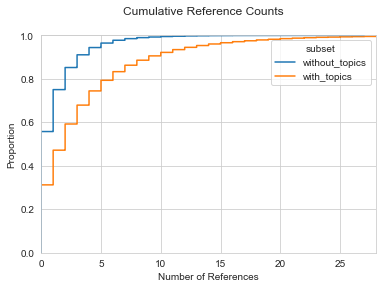

In [44]:
sns.set_style('whitegrid')

fig, ax = subplots()
sns.ecdfplot(data=degree, x='degree', hue='subset', hue_order=['without_topics', 'with_topics'], ax=ax)
suptitle('Cumulative Reference Counts')
ax.set_xlabel('Number of References')
ax.set_xlim(0, 28)
fig.savefig('count-cdf.png', dpi=300, bbox_inches='tight')

In [65]:
volume_totals = collections.defaultdict(int)
for node in graph.nodes:
    volume_totals[graph.nodes[node]['volume']] += 1
del volume_totals['Study Helps']
volume_totals

defaultdict(int,
            {'Old Testament': 23145,
             'New Testament': 7957,
             'Book of Mormon': 6604,
             'Pearl of Great Price': 635,
             'Doctrine and Covenants': 3654})

In [66]:
volume_degree_without_topics = {}
for key in volume_totals:
    mask = (degree.subset == 'without_topics') & (degree.volume == key)
    volume_degree_without_topics[key] = degree[mask].degree.values.sum()
volume_degree_without_topics

{'Old Testament': 17017,
 'New Testament': 7260,
 'Book of Mormon': 12278,
 'Pearl of Great Price': 1435,
 'Doctrine and Covenants': 7995}

In [67]:
relative_volume_degree_without_topics = {}
for key in volume_totals:
    relative_volume_degree_without_topics[key] = volume_degree_without_topics[key] / volume_totals[key]
relative_volume_degree_without_topics

{'Old Testament': 0.7352343918772953,
 'New Testament': 0.9124041724267941,
 'Book of Mormon': 1.8591762568140522,
 'Pearl of Great Price': 2.2598425196850394,
 'Doctrine and Covenants': 2.1880131362889985}

In [68]:
volume_degree_with_topics = {}
for key in volume_totals:
    mask = (degree.subset == 'with_topics') & (degree.volume == key)
    volume_degree_with_topics[key] = degree[mask].degree.values.sum()
volume_degree_with_topics

{'Old Testament': 35840,
 'New Testament': 28409,
 'Book of Mormon': 43108,
 'Pearl of Great Price': 5933,
 'Doctrine and Covenants': 30936}

In [69]:
relative_volume_degree_with_topics = {}
for key in volume_totals:
    relative_volume_degree_with_topics[key] = volume_degree_with_topics[key] / volume_totals[key]
relative_volume_degree_with_topics

{'Old Testament': 1.54849859580903,
 'New Testament': 3.570315445519668,
 'Book of Mormon': 6.52755905511811,
 'Pearl of Great Price': 9.343307086614173,
 'Doctrine and Covenants': 8.466338259441708}

In [70]:
delta_degree = {}
for key, value in volume_degree_with_topics.items():
    delta_degree[key] = value - volume_degree_without_topics[key]
delta_degree

{'Old Testament': 18823,
 'New Testament': 21149,
 'Book of Mormon': 30830,
 'Pearl of Great Price': 4498,
 'Doctrine and Covenants': 22941}

In [71]:
relative_delta_degree = {}
for key, value in relative_volume_degree_with_topics.items():
    relative_delta_degree[key] = value - relative_volume_degree_without_topics[key]
relative_delta_degree

{'Old Testament': 0.8132642039317347,
 'New Testament': 2.657911273092874,
 'Book of Mormon': 4.668382798304058,
 'Pearl of Great Price': 7.083464566929134,
 'Doctrine and Covenants': 6.278325123152709}

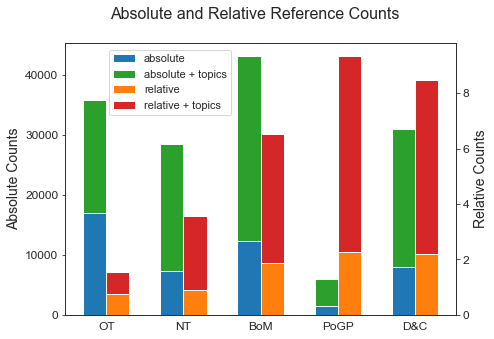

In [136]:
sns.set_style('white')
colors = sns.color_palette()
fig, ax = subplots(figsize=(7, 5))
ax.bar(range(5), volume_degree_without_topics.values(), color=colors[0], label='absolute', width=-0.3, align='edge')
ax.bar(range(5), delta_degree.values(), bottom=list(volume_degree_without_topics.values()), color=colors[2], label='absolute + topics', width=-0.3, align='edge')
ax.set_ylabel('Absolute Counts', fontsize=14)
ax2 = ax.twinx()
ax2.bar(range(5), relative_volume_degree_without_topics.values(), color=colors[1], label='relative', width=0.3, align='edge')
ax2.bar(range(5), relative_delta_degree.values(), bottom=list(relative_volume_degree_without_topics.values()), color=colors[3], label='relative + topics', width=0.3, align='edge')
ax2.set_ylabel('Relative Counts', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax.set_xticks(range(5))
ax.set_xticklabels([graph_lib.VOLUMES_SHORT[key] for key in volume_degree_without_topics], fontsize=12)
figlegend(loc=(0.22, 0.66), fontsize=11)
suptitle('Absolute and Relative Reference Counts', fontsize=16)
fig.savefig('count-bar.png', dpi=300, bbox_inches='tight')

# Get the largest subgraph

In [17]:
sizes = []
for component in nx.weakly_connected_components(graph):
    sizes.append(len(component))
sizes = np.asarray(sizes)

x = np.unique(sizes)
y = np.asarray([np.count_nonzero(sizes == size) for size in x])
df = pd.DataFrame({'size': x, 'count': y})
df

,size,count
0,1,13598
1,2,293
2,3,61
3,4,14
4,5,7
5,6,1
6,7,2
7,11,2
8,34066,1


In [18]:
# Prune the graph to the largest weakly connected component.
nodes = None
for component in nx.weakly_connected_components(graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(graph, nodes)
print(graph.number_of_nodes())
print(graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

48566
166449
34066
165456


In [20]:
degree_df = notebook_lib.assign_ranks(nx.in_degree_centrality(subgraph))
degree_df.head(10)

,key,score,rank
0,TG Faith,0.003699,1
1,TG Righteousness,0.003581,2
2,"TG Jesus Christ, Prophecies about",0.003288,3
3,"TG Prayer, Pray",0.003170,4
4,"TG Repent, Repentance",0.003082,5
5,TG Treasure,0.002818,6
6,"TG God, Spirit of",0.002701,7
7,TG Missionary Work,0.002671,8
8,TG Walking with God,0.002671,8
9,TG Grace,0.002642,10


In [21]:
degree_df = notebook_lib.assign_ranks(nx.pagerank(subgraph))
degree_df.head(10)

,key,score,rank
0,TG Faith,0.000925,1
1,"TG Idolatry, Idol",0.000895,2
2,TG Righteousness,0.000889,3
3,"TG Jesus Christ, Prophecies about",0.000867,4
4,"TG Disobedience, Disobey",0.000849,5
5,TG Angels,0.000836,6
6,TG Treasure,0.000819,7
7,"TG Prayer, Pray",0.000796,8
8,TG Grace,0.000776,9
9,TG Missionary Work,0.000759,10


In [22]:
hubs, authorities = nx.hits(subgraph, max_iter=1000)

In [23]:
notebook_lib.assign_ranks(hubs).head(10)

,key,score,rank
0,IttTC God,0.004928,1
1,IttTC Name of the Lord,0.004036,2
2,TG Spirit,0.003881,3
3,"TG Know, Knew, Known",0.003669,4
4,IttTC Jesus Christ—Son of God,0.003669,5
5,IttTC Jesus Christ,0.003243,6
6,TG Name of the Lord,0.002890,7
7,"TG Jesus Christ, Divine Sonship",0.002863,8
8,"IttTC Spirit, Holy/Spirit of the Lord",0.002852,9
9,"IttTC Repentance, Repent",0.002696,10


In [24]:
notebook_lib.assign_ranks(authorities).head(10)

,key,score,rank
0,2 Ne. 31:21,0.000872,1
1,Isa. 9:6,0.000855,2
2,Jacob 4:5,0.000841,3
3,2 Ne. 19:6,0.000833,4
4,Moro. 10:4,0.000804,5
5,Moses 6:57,0.000795,6
6,D&C 68:25,0.000761,7
7,D&C 13:1,0.000729,8
8,JS—H 1:17,0.000688,9
9,D&C 20:37,0.000688,10
